NOTEBOOK 3BIS: MODELADO MEDIANTE VOTING CLASSIFIER/ STACKING CLASSIFIER

Trabajo fin de bootcamp

**Night Traders:**

<font color = "blue">Illari Alvarez-Gil, Andrés Guzzo, Dairon Andrés Benites, José Carlos Amo</font>

Evaluación de diferentes modelos y selección del mejor enfoque
Durante el desarrollo de nuestro proyecto, llevamos a cabo pruebas con diversos modelos de aprendizaje automático para mejorar la predicción del cierre de huecos nocturnos bursátiles. Entre los modelos probados se encuentran redes neuronales convolucionales (CNN), Random Forest, Gradient Boosting y otros.

Después de realizar una exhaustiva comparación entre estos modelos, analizando su precisión, capacidad de generalización y tiempos de entrenamiento, hemos concluido que el enfoque que nos brinda los mejores resultados es el uso de un modelo de ensamble llamado Stacking Classifier.

El Stacking Classifier combina las predicciones de múltiples modelos base para generar un nuevo conjunto de datos, y luego entrena un modelo de meta-aprendizaje en estos datos. Esto nos permite aprovechar las fortalezas de cada uno de los modelos individuales y obtener una mejora en el rendimiento general.

Una vez seleccionado el modelo de Stacking Classifier como nuestro enfoque óptimo, lo aplicamos al conjunto de datos final para realizar nuestras predicciones. Este conjunto de datos está compuesto por los últimos 30 días de movimientos bursátiles, lo que nos permite obtener una visión actualizada y relevante del mercado.

Al aplicar nuestro modelo de Stacking Classifier en este data frame objetivo, podemos generar predicciones sobre el cierre de huecos nocturnos bursátiles para los próximos días, lo que nos brinda información valiosa para la toma de decisiones en el ámbito financiero y bursátil.

In [1]:
!pip install scikit-plot
!pip install eli5
!pip install scikit-optimize

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import multiprocessing
import warnings

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, StackingClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, 
                             precision_recall_fscore_support, roc_auc_score, ConfusionMatrixDisplay)
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import (cross_val_score, train_test_split, RepeatedKFold, GridSearchCV, 
                                     ParameterGrid, RandomizedSearchCV)
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

import scikitplot as skplt
import eli5
from eli5.sklearn import PermutationImportance

from sklearn.pipeline import Pipeline

from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

warnings.filterwarnings('ignore')




Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 kB 11.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107730 sha256=45ff1e0c92d8d766146226ca15502b37126f82dd17c226cebc384269a971f3d8
  Stored in directory: /root/.cache/pip/wheels/b8/58/ef/2cf4c306898c2338d51540e0922c8e0d6028e07007085c0004
Successfully built eli5
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 8.9 MB/s eta 0:00:00


In [2]:
# Cargar el dataset de train y reindexarlo
df_train = pd.read_csv('./train_preprocesado.csv', sep=',', decimal='.')
df_train = df_train.reset_index(drop=True)

# Cargar el dataset de test y reindexarlo
df_test = pd.read_csv('./test_preprocesado.csv', sep=',', decimal='.')
df_test = df_test.reset_index(drop=True)

# Cargar el dataset de validacion
df_validation = pd.read_csv('./validation_preprocesado.csv', sep=',', decimal='.')
df_validation = df_validation.reset_index(drop=True)
print(f'Dimensiones del dataset de training: {df_train.shape}')
print(f'Dimensiones del dataset de test: {df_test.shape}')
print(f'Dimensiones del dataset de validacion: {df_validation.shape}')

pd.options.display.max_rows = len(df_train)  # Para que muestre los listados completos a partir de aquí

Dimensiones del dataset de training: (20362, 68)
Dimensiones del dataset de test: (4826, 68)
Dimensiones del dataset de validacion: (2092, 68)


In [3]:
# Escalar los datos de train
# Seleccionar la etiqueta
y_train = df_train.loc[:, 'CLOSURE']
# Seleccionar las características y excluir la etiqueta
X_train = df_train.drop('CLOSURE', axis=1)
# Escalar las características
scaler = MinMaxScaler() # AQUI SE DEFINE EL SCALER
X_train = scaler.fit_transform(X_train)

# Escalar los datos de test usando el mismo scaler
# Seleccionar la etiqueta
y_test = df_test.loc[:, 'CLOSURE']
# Seleccionar las características y excluir la etiqueta
X_test = df_test.drop('CLOSURE', axis=1)
# Escalar las características utilizando el mismo scaler que se ajustó en el conjunto de datos de entrenamiento
X_test = scaler.transform(X_test)

# Escalar los datos de test usando el mismo scaler
# Seleccionar la etiqueta
Y_validation = df_validation.loc[:, 'CLOSURE']
# Seleccionar las características y excluir la etiqueta
X_validation = df_validation.drop('CLOSURE', axis=1)
# Escalar las características utilizando el mismo scaler que se ajustó en el conjunto de datos de entrenamiento
X_validation = scaler.transform(X_validation)

In [4]:
#  Comprobacion
# Calcular la media y la desviación estándar de los datos normalizados
mean = np.mean(X_train)
std = np.std(X_train)

# Definir un rango de valores normales
lower_bound = mean - 3 * std
upper_bound = mean + 3 * std

# Contar cuántos valores están fuera de este rango en train
outliers = np.sum((X_train < lower_bound) | (X_train > upper_bound))
print(f"Número de valores atípicos en X_train: {outliers}")

# Contar cuántos valores están fuera de este rango en test
outliers = np.sum((X_test < lower_bound) | (X_test > upper_bound))
print(f"Número de valores atípicos en X_test: {outliers}")

# Contar cuántos valores están fuera de este rango en validation
outliers = np.sum((X_validation < lower_bound) | (X_validation > upper_bound))
print(f"Número de valores atípicos en X_validation: {outliers}")

Número de valores atípicos en X_train: 0
Número de valores atípicos en X_test: 4
Número de valores atípicos en X_validation: 0


**Una vez preparados los conjuntos de datos empezamos con el modelado.**

**Hemos elegido desarrollar un modelo de Voting Classifier que combina varios modelos para abordar nuestro problema de clasificación binaria por varias razones:**

**-Alta precisión de predicción:** Los modelos de Voting Classifier combinan las fortalezas de varios modelos individuales, lo que puede resultar en un alto rendimiento en términos de precisión de predicción para problemas de clasificación binaria. Esto permite capturar patrones y relaciones complejas entre las variables predictoras y la variable objetivo.

**-Robustez ante datos ruidosos y faltantes:** dado que el Voting Classifier integra múltiples modelos, es capaz de manejar datos ruidosos y faltantes de manera efectiva. La diversidad de los modelos subyacentes puede ayudar a compensar las debilidades de los modelos individuales, lo que resulta en un enfoque más robusto en comparación con el uso de un solo modelo de aprendizaje automático.

**-Interpretación de los resultados:** Aunque el Voting Classifier en sí mismo no proporciona directamente información sobre la importancia relativa de cada variable, al utilizar modelos que pueden hacerlo (como Gradient Boosting o Random Forest), es posible obtener una idea de cómo se relacionan las variables con la variable objetivo y qué variables son las más importantes para la predicción.

**-Escalabilidad:** Los modelos de Voting Classifier son escalables y pueden manejar grandes conjuntos de datos de manera eficiente. Además, estos modelos pueden beneficiarse de la paralelización, lo que significa que los modelos subyacentes pueden entrenarse en paralelo para acelerar el tiempo de entrenamiento.

El código y las herramientas que utilizamos aquí tienen como objetivo mejorar la precisión de un modelo de clasificación. A través de la búsqueda de hiperparámetros y el uso de técnicas de ensamblaje, tratamos de mejorar el rendimiento del modelo. En concreto, se realizan las siguientes acciones:

1.Identificar los mejores hiperparámetros para diferentes modelos de clasificación, como RandomForestClassifier, LogisticRegression, LGBMClassifier, KNeighborsClassifier y SVC, utilizando GridSearchCV y RandomizedSearchCV.

2.Crear un VotingClassifier, que es un ensamblaje de clasificadores, utilizando los modelos individuales ajustados con los mejores hiperparámetros encontrados en el paso anterior.

3.Utilizar técnicas de optimización bayesiana para ajustar los hiperparámetros del XGBoostClassifier, a través de la biblioteca scikit-optimize y su función BayesSearchCV.

4.Crear un StackingClassifier, que es otro tipo de ensamblaje de clasificadores, utilizando el XGBoostClassifier optimizado junto con otros modelos individuales.

5.Evaluar y comparar el rendimiento de los diferentes enfoques de ensamblaje y modelos individuales utilizando la precisión (accuracy) como métrica de evaluación.

El objetivo de utilizar estos métodos y herramientas es identificar y combinar modelos que, al trabajar juntos, puedan mejorar el rendimiento general del modelo final. Esto puede resultar en una mayor precisión en la clasificación y, en última instancia, en una mejor solución para el problema en cuestión.






**Estos son nuestros rangos de hiperparámetros para cada modelo:**

In [20]:
# Hiperparámetros de RandomForest
rf_params = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Hiperparámetros de LogisticRegression
lr_params = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10],
    'solver': ['liblinear']
}

# Hiperparámetros de LGBMClassifier
lgbm_params = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [20, 40, 60, 80, 100],
    'num_leaves': [15, 31, 63],
    'min_child_samples': [10, 20, 30]
}

# Hiperparámetros de KNeighborsClassifier
knn_params = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance']
}

# Hiperparámetros de XGBClassifier
xgb_params = {
    'n_estimators': Integer(10, 200),
    'learning_rate': Real(0.01, 0.2, 'log-uniform'),
    'max_depth': Integer(3, 10),
    'min_child_weight': Integer(1, 10),
    'subsample': Real(0.5, 1.0),
    'colsample_bytree': Real(0.5, 1.0)
}



El siguiente paso sera buscar los mejores hiperparámetros de diferentes modelos de aprendizaje automático, usando la técnica de búsqueda Bayesiana. 

La búsqueda se realiza utilizando la validación cruzada y el criterio de evaluación es la precisión (accuracy). Se utilizan cinco modelos diferentes: RandomForest, LogisticRegression, LGBMClassifier, KNeighborsClassifier y XGBClassifier.

 La técnica de búsqueda Bayesiana es útil porque utiliza información previa para guiar la búsqueda de hiperparámetros, lo que a menudo conduce a una búsqueda más eficiente y efectiva en comparación con la búsqueda aleatoria. 

In [21]:

# Búsqueda de hiperparámetros de RandomForest
rf = RandomForestClassifier(random_state=42)
rf_search = BayesSearchCV(rf, rf_params, n_iter=20, cv=5, scoring='accuracy', n_jobs=-1, random_state=42)
rf_search.fit(X_validation, Y_validation)
print("Mejores hiperparámetros de RandomForest:", rf_search.best_params_)

# Búsqueda de hiperparámetros de LogisticRegression
lr = LogisticRegression(random_state=42)
lr_search = BayesSearchCV(lr, lr_params, n_iter=20, cv=5, scoring='accuracy', n_jobs=-1, random_state=42)
lr_search.fit(X_validation, Y_validation)
print("Mejores hiperparámetros de LogisticRegression:", lr_search.best_params_)

# Búsqueda de hiperparámetros de LGBMClassifier
lgbm = LGBMClassifier(random_state=42)
lgbm_search = BayesSearchCV(lgbm, lgbm_params, n_iter=20, cv=5, scoring='accuracy', n_jobs=-1, random_state=42)
lgbm_search.fit(X_validation, Y_validation)
print("Mejores hiperparámetros de LGBMClassifier:", lgbm_search.best_params_)

# Búsqueda de hiperparámetros de KNeighborsClassifier
knn = KNeighborsClassifier()
knn_search = BayesSearchCV(knn, knn_params, n_iter=20, cv=5, scoring='accuracy', n_jobs=-1, random_state=42)
knn_search.fit(X_validation, Y_validation)
print("Mejores hiperparámetros de KNeighborsClassifier:", knn_search.best_params_)

# Búsqueda de hiperparámetros de XGBClassifier
xgb = XGBClassifier(random_state=42)
xgb_search = BayesSearchCV(xgb, xgb_params, n_iter=20, cv=5, scoring='accuracy', n_jobs=-1, random_state=42)
xgb_search.fit(X_validation, Y_validation)
print("Mejores hiperparámetros de XGBClassifier:", xgb_search.best_params_)

Mejores hiperparámetros de RandomForest: OrderedDict([('max_depth', 20), ('min_samples_leaf', 2), ('min_samples_split', 5), ('n_estimators', 100)])
Mejores hiperparámetros de LogisticRegression: OrderedDict([('C', 10.0), ('penalty', 'l1'), ('solver', 'liblinear')])
Mejores hiperparámetros de LGBMClassifier: OrderedDict([('learning_rate', 0.1), ('min_child_samples', 10), ('n_estimators', 60), ('num_leaves', 31)])
Mejores hiperparámetros de KNeighborsClassifier: OrderedDict([('n_neighbors', 11), ('weights', 'uniform')])
Mejores hiperparámetros de XGBClassifier: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.01), ('max_depth', 7), ('min_child_weight', 1), ('n_estimators', 143), ('subsample', 0.5)])


**los mejores valores por modelo son:**




In [6]:
from sklearn.ensemble import StackingClassifier

# Crear instancias de los modelos individuales con los mejores , estos hiperparametros son el resultado anterior

# For XGBClassifier
xgb = XGBClassifier(colsample_bytree=0.7224162561505759, learning_rate=0.15677815829096733, max_depth=4, min_child_weight=5, n_estimators=46, subsample=0.7268326719031495, random_state=42)

# For RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, min_samples_split=5, min_samples_leaf=2, max_depth=20, random_state=42)

# For LogisticRegression
lr = LogisticRegression(solver='liblinear', penalty='l1', C=10.0, random_state=42)

# For LGBMClassifier
lgbm = LGBMClassifier(num_leaves=31, n_estimators=60, min_child_samples=10, learning_rate=0.1, random_state=42)

# For KNeighborsClassifier
knn = KNeighborsClassifier(weights='uniform', n_neighbors=11)

# Crear el Stacking Classifier
stacking_clf = StackingClassifier(estimators=[('xgb', xgb), ('rf', rf), ('lr', lr), ('lgbm', lgbm), ('knn', knn)], final_estimator=LogisticRegression(), cv=5)

# Entrenar el Stacking Classifier
stacking_clf.fit(X_train, y_train)

# Evaluar el rendimiento en el conjunto de prueba
y_pred = stacking_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Stacking Classifier Accuracy:", accuracy)


'# Entrenar el Stacking Classifier\nstacking_clf.fit(X_train, y_train)\n\n# Evaluar el rendimiento en el conjunto de prueba\ny_pred = stacking_clf.predict(X_test)\naccuracy = accuracy_score(y_test, y_pred)\nprint("Stacking Classifier Accuracy:", accuracy)'

In [7]:
from sklearn.ensemble import VotingClassifier
# Crear el Voting Classifier
voting_clf = VotingClassifier(estimators=[('lgbm', lgbm), ('xgb', xgb), ('rf', rf), ('lr', lr), ('knn', knn)], voting='hard')

# Entrenar el Voting Classifier
voting_clf.fit(X_train, y_train)
modelo1 = voting_clf.fit(X_train, y_train)
# Evaluar el rendimiento en el conjunto de prueba
y_pred_voting = voting_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_voting)
print("Voting Classifier Accuracy:", accuracy)

Voting Classifier Accuracy: 0.6811023622047244


comparando con modelos de stacking y voting, se ve alguna mejora en el accuracy con el stacking pero el stacking tiene un modelo final(modelo meta) que le podemos buscar hiperparámetros especificos para este caso y ver si mejora nuestro accuracy.

In [27]:


# Definir el espacio de búsqueda de hiperparámetros para el modelo meta
meta_params = {
    'penalty': ['l1', 'l2'],
    'C': (1e-6, 1000.0, 'log-uniform'),
    'fit_intercept': [True, False],
    'solver': ['liblinear', 'saga']
}

# Crear el modelo meta con BayesSearchCV para la búsqueda de hiperparámetros
meta_model = BayesSearchCV(LogisticRegression(random_state=42),
                           meta_params,
                           n_iter=10,
                           cv=5,
                           scoring='accuracy',
                           n_jobs=-1,
                           random_state=42)

# Crear el Stacking Classifier con el modelo meta
stacking_clf_meta = StackingClassifier(estimators=[('xgb', xgb), ('rf', rf), ('lr', lr), ('lgbm', lgbm), ('knn', knn)], final_estimator=meta_model, cv=5)

# Entrenar el Stacking Classifier
stacking_clf_meta.fit(X_train, y_train)

# Evaluar el rendimiento en el conjunto de prueba
y_pred = stacking_clf_meta.predict(X_test)
accuracy_meta = accuracy_score(y_test, y_pred_meta)
print("Stacking Classifier Accuracy:", accuracy_meta)


Stacking Classifier Accuracy: 0.6817239950269374


La seleccion del hiperparemtro de modelo metA no es una bueno opcion visto que nos baja el accuracy.

AMBOS MODELOS TIENEN UNA GRAN SIMILITUD En SU ACCURACY. PROCEDEREMOS CON AMBOS MODELOS.

**Vamos a representar la matriz de confusión.**

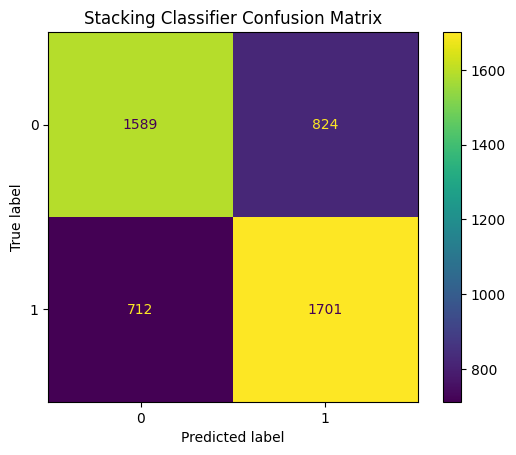

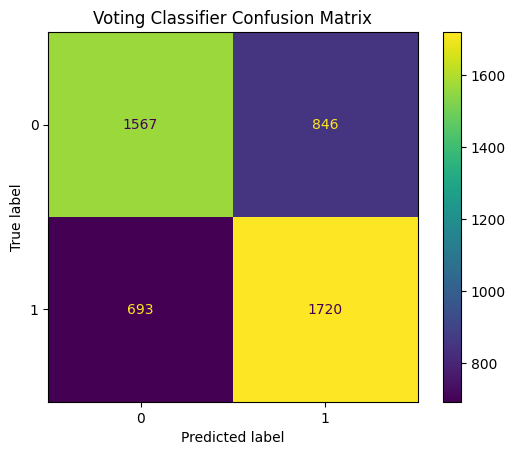

In [30]:
# Matriz de confusión para Stacking Classifier
y_pred_stacking = stacking_clf.predict(X_test)
confusion_matrix_stacking = confusion_matrix(y_test, y_pred_stacking)
ConfusionMatrixDisplay(confusion_matrix_stacking).plot()
plt.title('Stacking Classifier Confusion Matrix')
plt.show()

# Matriz de confusión para Voting Classifier
y_pred_voting = voting_clf.predict(X_test)
confusion_matrix_voting = confusion_matrix(y_test, y_pred_voting)
ConfusionMatrixDisplay(confusion_matrix_voting).plot()
plt.title('Voting Classifier Confusion Matrix')
plt.show()


In [31]:
# Numericamente:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(f'True Negative TN: {tn}, False Positive FP: {fp}, False Negative FN: {fn}, True Positive TP: {tp}')

True Negative TN: 1589, False Positive FP: 824, False Negative FN: 712, True Positive TP: 1701


**Vamos a evaluar el rendimiento mediante las curvas Lift y ROC.**

**La curva de Lift representa la relación entre la tasa de verdaderos positivos (TPR) y la tasa de falsos positivos (FPR) a medida que se aumenta el umbral de clasificación en el modelo. **

**En la curva Lift, el eje Y representa el Lift, que es la razón entre la tasa de verdaderos positivos (TPR) y la proporción de casos positivos en los datos (también conocido como prevalencia). El eje X representa la proporción acumulativa de los datos que se seleccionan como positivos a medida que se aumenta el umbral de clasificación en el modelo.**

**En general, una curva Lift se considera buena si la curva de Lift está por encima de la línea de referencia, que representa la tasa de verdaderos positivos que se esperaría si se hiciera una selección aleatoria sin el uso del modelo.**

**La curva ROC representa la relación entre la tasa de verdaderos positivos (TPR) y la tasa de falsos positivos (FPR) para cada umbral de clasificación posible en el modelo.**

**En la curva ROC, el eje Y representa la Tasa de Verdaderos Positivos (TPR) y el eje X representa la Tasa de Falsos Positivos (FPR). Cada punto en la curva ROC representa el par (TPR, FPR) para un umbral de clasificación específico en el modelo.**

**En general, una curva ROC se considera buena si la curva se acerca lo más posible al ángulo superior izquierdo del gráfico, que representa una tasa alta de verdaderos positivos y una tasa baja de falsos positivos. El área bajo la curva (AUC-ROC) se utiliza comúnmente como una métrica para evaluar el rendimiento general del modelo. Una AUC-ROC cercana a 1 indica un modelo con un rendimiento excelente, mientras que una AUC-ROC cercana a 0.5 indica un modelo que no tiene capacidad para discriminar entre las clases.**

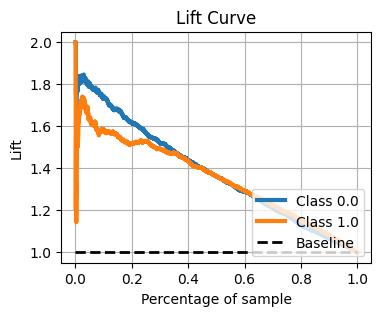

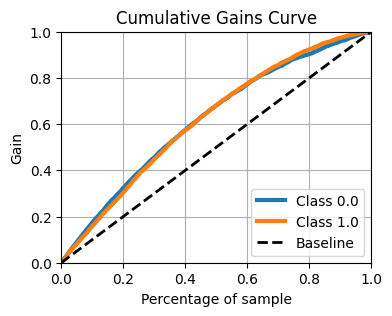

In [32]:
# Curvas Lift y ROC
prediction_of_probability_test = stacking_clf.predict_proba(X_test)

fig, ax = plt.subplots(figsize=(4,3))
skplt.metrics.plot_lift_curve(y_test, prediction_of_probability_test, ax=ax)
plt.show()

fig, ax = plt.subplots(figsize=(4,3))
skplt.metrics.plot_cumulative_gain(y_test, prediction_of_probability_test, ax=ax)
plt.show()



**En el primer gráfico, como ambas curvas de lift están por encima de la línea base, esto indica que el modelo es efectivo en ambas clases. Sin embargo lo deseable sería que estuviera dibujada "más arriba".**

**En el segundo gráfico, la diagonal etiquetada como "Baseline" es la línea de ganancia aleatoria (random gains line). Esta línea representa la cantidad de casos positivos que se esperarían identificar si se hiciera una selección aleatoria sin el uso del modelo.**

**Como en ese segundo gráfico las curvas de ganancia acumulativa están por encima de la línea de ganancia aleatoria, significa que nuestro modelo es efectivo para identificar casos positivos**

## Ahora vamos a tratar de modelar las probabilidades de pertenencia a cada clase.

In [33]:
from sklearn.metrics import accuracy_score

# Evaluar el rendimiento del modelo en el conjunto de prueba
y_pred = voting_clf.predict(X_test_reducido)
accuracy = accuracy_score(y_test, y_pred)
print("Voting Classifier Accuracy:", accuracy)


NameError: ignored

**Vamos a tratar de modelar las probabilidades de pertenencia a cada clase.**
**En nuestro modelo, al aplicar '.predict()' se devuelve 1 (el gap se cierra en el mismo día) o 0 (el gap no se cierra en el mismo día) para cada observación de test. Sin embargo, no se dispone de ningún tipo de información sobre la seguridad con la que el modelo realiza esta asignación.**

**En cambio, con '.predict_proba()' lo que se obtiene es la probabilidad de que cada observación pueda, segíun el modelo, pertenecer a cada una de las clases.**

nota: para ver la probabilidad de pertenencia a cada clase, se usa la función '.predict_proba()'. La cual funciona solo con el modelo stacking.


El modelo voting  se configuró para realizar votación 'hard', lo que significa que solo se considera la clase predicha más frecuente por los clasificadores base. En este caso, no es posible obtener las probabilidades de predicción.

In [34]:
# Predicción de probabilidades
modelo_final = stacking_clf
predicciones = modelo_final.predict_proba(X = X_test)
predicciones[:5, :]

# Clasificación empleando la clase más probable
df_predicciones = pd.DataFrame(data=predicciones, columns=['0', '1'])
df_predicciones['clasificacion_default_0.5'] = np.where(df_predicciones['0'] > df_predicciones['1'], 0, 1)
df_predicciones.head(10)

,0,1,clasificacion_default_0.5
0,0.284231,0.715769,1
1,0.386967,0.613033,1
2,0.280394,0.719606,1
3,0.524577,0.475423,0
4,0.750929,0.249071,0
5,0.387447,0.612553,1
6,0.293665,0.706335,1
7,0.303659,0.696341,1
8,0.524202,0.475798,0
9,0.582041,0.417959,0


**Finalmente vamos a ver cuáles son las variables más importantes en el modelo.**

**Para ello usamos el método "feature_importances_" perteneciente a la librería Scikit-learn.

**Para modelos sin atributos 'feature_importances_'. usaremos 'permutation_importance' para obtener la importancia de las características.***

Luego eliminaremoslas variables menos importantes (10 de ellas) y volveremos a entrenar el modelo con los datos reducidos para el compruebe de su rendimiento.

In [35]:
from eli5.sklearn.unhashing import FeatureNames
from sklearn.feature_extraction.text import FeatureHasher


# Función para obtener importancia promedio de las características en VotingClassifier
def feature_importances_voting(voting_clf):
    importances = []
    for name, model in voting_clf.named_estimators_.items():
        if hasattr(model, 'feature_importances_'):
            importances.append(model.feature_importances_)
        else:
            # Para modelos sin atributo 'feature_importances_', utilizamos 'permutation_importance'
            imp = permutation_importance(
                estimator=model,
                X=X_train,
                y=y_train,
                n_repeats=5,
                n_jobs=multiprocessing.cpu_count() - 1,
                random_state=123
            )
            importances.append(imp.importances_mean)
    return np.mean(importances, axis=0)

# Obtener la importancia de las características para el VotingClassifier
importances = feature_importances_voting(voting_clf)

#nombres de columnas
nombres_predictores = ['Open', 'Volume', 'Dividends', 'Stock Splits', 'company',
       'SMA_10_Volume', 'EMA_10_Open', 'EMA_10_Volume', 'MACD_6_12_9_Close',
       'MACD_6_12_9_Close_signal', 'MACD_6_12_9_High',
       'MACD_6_12_9_High_signal', 'MACD_6_12_9_Low', 'MACD_6_12_9_Low_signal',
       'MACD_6_12_9_Open', 'MACD_6_12_9_Open_signal', 'MACD_6_12_9_Volume',
       'MACD_6_12_9_Volume_signal', 'RSI', 'BOLLINGER_21_2_high',
       'BOLLINGER_21_2_low', 'BOLLINGER_21_2_medium', 'BOLLINGER_21_2_bbhi',
       'BOLLINGER_21_2_bbli', 'BOLLINGER_21_2_bbw', 'BOLLINGER_21_2_bbp',
       'STD_DEV_14_Close', 'STD_DEV_14_High', 'STD_DEV_14_Low',
       'STD_DEV_14_Open', 'STD_DEV_14_Volume', 'CCI', 'ESTOCASTICO_14_3_%K',
       'ESTOCASTICO_14_3_%D', 'WILLIAMSR_14', 'ADI', 'CMF_21', 'PSAR_0.02_0.2',
       'PSAR_0.02_0.2_down_indicator', 'PSAR_0.02_0.2_up_indicator', 'ATR_14',
       'ADX_14', 'ADX_14_neg', 'ADX_14_pos', 'ROC_Close_12', 'ROC_High_12',
       'ROC_Low_12', 'ROC_Open_12', 'ROC_Volume_12', 'OBV', 'MFI_14',
       'ICHIMOKU_A_9_26', 'ICHIMOKU_B_26_52', 'ICHIMOKU_BASE_LINE_9_26',
       'ICHIMOKU_CONVERSION_LINE_9_26', 'DPO_Close_20', 'DPO_High_20',
       'DPO_Low_20', 'DPO_Open_20', 'DPO_Volume_20', 'NVI', 'PRE_OPEN',
       'GAP_%', 'GAP_€', 'WEEKDAY', 'WEEK', 'MONTH']

# Crear un DataFrame con la importancia de las características
importance_predictores = pd.DataFrame({'predictor': nombres_predictores, 'importancia': importances})
importancia_predictores_orden = importance_predictores.sort_values('importancia', ascending=False)

print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
print(importancia_predictores_orden)

# Eliminar las 10 variables menos importantes
variables_a_eliminar = importancia_predictores_orden.tail(10)['predictor'].index

dataframe_X_train = pd.DataFrame(X_train, columns=nombres_predictores)
dataframe_X_test = pd.DataFrame(X_test, columns=nombres_predictores)
dataframe_X_validation = pd.DataFrame(X_validation, columns=nombres_predictores)

dataframe_X_train_reducido = dataframe_X_train.drop(dataframe_X_train.columns[variables_a_eliminar], axis=1)
dataframe_X_test_reducido = dataframe_X_test.drop(dataframe_X_test.columns[variables_a_eliminar], axis=1)
dataframe_X_validation_reducido = dataframe_X_validation.drop(dataframe_X_validation.columns[variables_a_eliminar], axis=1)

X_train_reducido = dataframe_X_train_reducido.to_numpy()
X_test_reducido = dataframe_X_test_reducido.to_numpy()
X_validation_reducido = dataframe_X_validation_reducido.to_numpy()

# Ajustar el modelo con los nuevos datos reducidos
voting_clf.fit(X_train_reducido, y_train)

# Evaluar el modelo con datos reducidos y mostrar las métricas
y_pred_reducido = voting_clf.predict(X_test_reducido)
voting_accuracy_reducido = accuracy_score(y_test, y_pred_reducido)

print("Voting Classifier Accuracy (reduced features):", voting_accuracy_reducido)


Importancia de los predictores en el modelo
-------------------------------------------
                        predictor  importancia
62                          GAP_%    24.868123
63                          GAP_€    22.031880
40                         ATR_14    16.212715
49                            OBV    14.809355
35                            ADI    11.608216
24             BOLLINGER_21_2_bbw    11.206349
60                            NVI    10.205849
65                           WEEK     9.611598
4                         company     9.209907
41                         ADX_14     9.006664
31                            CCI     8.605324
32            ESTOCASTICO_14_3_%K     8.209829
57                     DPO_Low_20     8.205171
59                  DPO_Volume_20     7.805889
48                  ROC_Volume_12     7.805299
55                   DPO_Close_20     7.605190
44                   ROC_Close_12     7.204599
5                   SMA_10_Volume     7.010252
50                 

In [36]:
# Ajustar el modelo con los nuevos datos reducidos
stacking_clf.fit(X_train_reducido, y_train)

# Evaluar el modelo con datos reducidos y mostrar las métricas
y_pred_reducido = stacking_clf.predict(X_test_reducido)
voting_accuracy_reducido = accuracy_score(y_test, y_pred_reducido)

print("Voting Classifier Accuracy (reduced features):", voting_accuracy_reducido)

Voting Classifier Accuracy (reduced features): 0.6825528387898881


Comparacion para eleccion del mejor modelo obtenido.

Voting Classifier Accuracy (reduced features): 0.677579776212184
Stacking Classifier Accuracy (reduced features): 0.6825528387898881


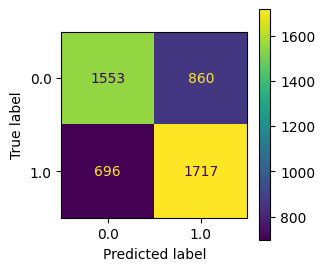

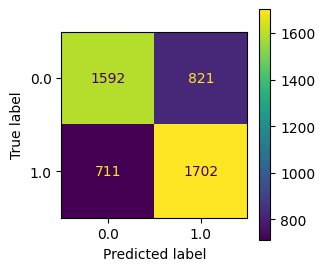

Classification Report - Voting Classifier
              precision    recall  f1-score   support

         0.0       0.69      0.64      0.67      2413
         1.0       0.67      0.71      0.69      2413

    accuracy                           0.68      4826
   macro avg       0.68      0.68      0.68      4826
weighted avg       0.68      0.68      0.68      4826

Classification Report - Stacking Classifier
              precision    recall  f1-score   support

         0.0       0.69      0.66      0.68      2413
         1.0       0.67      0.71      0.69      2413

    accuracy                           0.68      4826
   macro avg       0.68      0.68      0.68      4826
weighted avg       0.68      0.68      0.68      4826



In [37]:
# Evaluar el modelo con datos reducidos y mostrar las métricas
y_pred_reducido_voting = voting_clf.predict(X_test_reducido)
voting_accuracy_reducido = accuracy_score(y_test, y_pred_reducido_voting)
print("Voting Classifier Accuracy (reduced features):", voting_accuracy_reducido)

y_pred_reducido_stacking = stacking_clf.predict(X_test_reducido)
stacking_accuracy_reducido = accuracy_score(y_test, y_pred_reducido_stacking)
print("Stacking Classifier Accuracy (reduced features):", stacking_accuracy_reducido)

# Matriz de confusión para Voting Classifier
predicciones_voting = voting_clf.predict(X_test_reducido)
fig, ax = plt.subplots(figsize=(3, 3))
ConfusionMatrixDisplay.from_predictions(y_test, predicciones_voting, ax=ax)
plt.show()

# Matriz de confusión para Stacking Classifier
predicciones_stacking = stacking_clf.predict(X_test_reducido)
fig, ax = plt.subplots(figsize=(3, 3))
ConfusionMatrixDisplay.from_predictions(y_test, predicciones_stacking, ax=ax)
plt.show()

# Classification report para Voting Classifier
print("Classification Report - Voting Classifier")
print(classification_report(y_test, predicciones_voting))

# Classification report para Stacking Classifier
print("Classification Report - Stacking Classifier")
print(classification_report(y_test, predicciones_stacking))

Al revisar todos los resultados, se puede apreciar que el Voting Classifier es mejor que el Stacking Classifier y que reduciendo las características empeora el accuracy del modelo ligeramente asi que nos quedaremos con el Stacking Classifier.

Aplicacion de Modelo en df a predecir con datos actuales

In [38]:

# Cargar los datos preprocesados
df_predecir = pd.read_csv('ibex_predecir_preprocesado.csv', sep=',', decimal='.')

df_predecir = df_predecir.reset_index(drop=True)

# Seleccionar las características y excluir la etiqueta
df_predecir=df_predecir.drop('CLOSURE', axis=1)

# Escalar las características utilizando el mismo scaler que se ajustó en el conjunto de datos de entrenamiento
X_predecir = scaler.transform(df_predecir)

# Predecir con el modelo
y_pred = stacking_clf.predict(X_predecir)

# Agregar las predicciones al dataframe
df_predecir['PREDICTION'] = y_pred

# Descargar el archivo con las predicciones
df_predecir.to_csv('ibex_predicciones.csv', index=False)
from google.colab import files
files.download('ibex_predicciones.csv')

ValueError: ignored

In [ ]:
print(y_pred)
print(df_predecir['CLOSURE'])